In [0]:
!pip install -U googlemaps
!pip install geopandas
!pip install geopy

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import googlemaps
from datetime import datetime
from geopy.extra.rate_limiter import RateLimiter
import folium  
import folium.plugins
import branca
import branca.colormap as cm


In [0]:
# 1-a)
df = pd.read_csv('delay.csv', header=0)
# remove NAN values
df.dropna(inplace=True)
# print(df.shape)
# df.head()
df['OVERALL_DELAY'] = df['CARRIER_DELAY'] + df['WEATHER_DELAY'] + df['NAS_DELAY'] + df['SECURITY_DELAY'] + df['LATE_AIRCRAFT_DELAY']
# print(df.shape)
#df.head(20)
df_sorted = df.sort_values(['ORIGIN_AIRPORT_ID', 'OP_UNIQUE_CARRIER'], ascending=[True, True])
# df_sorted.head(20)

In [7]:
# remove ORIGIN_AIRPORT_ID with less than 5 repetition

df_sorted['ORIGIN_AIRPORT_COUNTS'] = df_sorted['ORIGIN_AIRPORT_ID'].map(df_sorted['ORIGIN_AIRPORT_ID'].value_counts())
df_sorted = df_sorted[df_sorted['ORIGIN_AIRPORT_COUNTS'] > 4]
df_sorted.drop('ORIGIN_AIRPORT_COUNTS', axis=1, inplace=True)

print(df_sorted.shape)
print("The number of rows that were removed: ", len(df)-len(df_sorted))
df_sorted.head()

(70837, 8)
The number of rows that were removed:  45


,OP_UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,OVERALL_DELAY
156947,DL,10135,287.0,0.0,0.0,0.0,0.0,287.0
162771,DL,10135,0.0,56.0,0.0,0.0,0.0,56.0
179583,DL,10135,17.0,0.0,41.0,0.0,0.0,58.0
202890,EV,10135,0.0,0.0,0.0,0.0,59.0,59.0
202898,EV,10135,0.0,0.0,0.0,0.0,358.0,358.0


In [40]:
total_delay = df_sorted['OVERALL_DELAY'].sum()
df_sorted['OVERALL_DELAY_PERC'] = df_sorted['OVERALL_DELAY']*100/total_delay
df_sorted = df_sorted.sort_values('OP_UNIQUE_CARRIER', ascending=True)
# df_sorted.head()

# sum up airlines delay 1
df_rank_1 = df_sorted.groupby('OP_UNIQUE_CARRIER', as_index=False)['OVERALL_DELAY_PERC'].sum()
df_rank_1 = df_rank_1.sort_values('OVERALL_DELAY_PERC', ascending=False)

# sum up airports delay 2
df_rank_2 = df_sorted.groupby('ORIGIN_AIRPORT_ID', as_index=False)['OVERALL_DELAY'].sum()
df_rank_2 = df_rank_2.sort_values('OVERALL_DELAY', ascending=False)

list_rank = df_rank_1['OVERALL_DELAY_PERC'].tolist()
list_rank_normalize = [i / max(list_rank) for i in list_rank]
list_rank_normalize.sort(reverse=True)
df_rank_1['PERCENTILE'] = list_rank_normalize
df_rank_1.head()

# print the airlines with over 90th percentile of overall delays ...
# in 2016 for the month of January.
df_1_a = df_rank_1[[df_rank_1['PERCENTILE'] > 0.90][0]]
foo1 = df_1_a['OP_UNIQUE_CARRIER'].tolist()
print("1-a) The top three airlines with the most delay: ", foo1)

1-a) The top three airlines with the most delay:  ['AA', 'WN', 'OO']


In [0]:
df_rank_2.head()
df_rank_2.to_csv('delay_airport.csv', index=False)

In [0]:
#####################################################

In [10]:
# 1-b) percentage of airlines most at fault contribute to the overall delays
foo2 = list_rank[0:len(df_1_a)]
print("1-b) Percentages of the top three airlines with the most delay: ", ['%.2f' % elem for elem in foo2])

1-b) Percentages of the top three airlines with the most delay:  ['16.89', '15.93', '15.78']


In [0]:
#####################################################

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


1-c) Airlines fault contribution to the overall delays: 


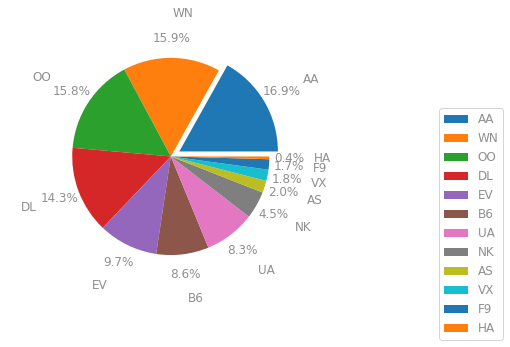

In [12]:
# 1-c) visualisation
airlines = df_rank_1['OP_UNIQUE_CARRIER'].unique().tolist()
percentages = df_rank_1['OVERALL_DELAY_PERC'].unique().tolist()

fig, ax = plt.subplots()
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['text.color'] = '#909090'
plt.rcParams['axes.labelcolor']= '#909090'
plt.rcParams['xtick.color'] = '#909090'
plt.rcParams['ytick.color'] = '#909090'
plt.rcParams['font.size'] = 12
color_palette_list = sns.color_palette()
#labels = airlines
#percentages = [91, 9]
explode=(0.1,0,0,0,0,0,0,0,0,0,0,0)
ax.pie(percentages, explode=explode, labels=airlines,  
       colors=color_palette_list[0:12], autopct='%0.1f%%', 
       shadow=False, startangle=0,   
       pctdistance=1.2,labeldistance=1.45)
ax.axis('equal')
ax.legend(frameon=True, bbox_to_anchor=(1.5,0.75))
print('1-c) Airlines fault contribution to the overall delays: ')

In [0]:
#####################################################

In [14]:
# 1-d) 
# as the first step .asp file converted to csv file with 2 col
df_names = pd.read_csv('US_airports.csv', header=0)

list_zeros = [0] * len(df_names)
df_names['Latitude'] = list_zeros
df_names['Longitude'] = list_zeros

gmaps = googlemaps.Client(key='Enter_your_key')
# Geocoding an address
for i in range(len(df_names)):
    #i=6532
    geocode_result = gmaps.geocode(df_names['Description'][i])
    if not geocode_result:
      lat = 0
      lng = 0
    else:
      lat = geocode_result[0]['geometry']['location']['lat']
      lng = geocode_result[0]['geometry']['location']['lng']

    df_names.loc[i,'Latitude'] = lat
    df_names.loc[i,'Longitude'] = lng

df_names.tail()
# df_names.to_csv('US_lat_lng.csv',index=False)

,ORIGIN_AIRPORT_ID,Description,Latitude,Longitude
424,15919,"Fayetteville, AR: Northwest Arkansas Regional",36.082156,-94.171854
425,15991,"Yakutat, AK: Yakutat Airport",59.509939,-139.668631
426,16101,"Yakima, WA: Yakima Air Terminal/McAllister Field",46.570268,-120.539824
427,16133,"Youngstown/Warren, OH: Youngstown-Warren Regional",41.099911,-80.649968
428,16218,"Yuma, AZ: Yuma MCAS/Yuma International",32.656383,-114.581469


In [106]:
# 1-e) 
# let's merge two datasets to find the common airports in them
df_merged = pd.merge(df_rank_2, df_names, on=['ORIGIN_AIRPORT_ID'], how='inner')
df_merged.to_csv('merged_airports_latlng.csv',index=False)

lat0 = list(df_merged['Latitude'])
lng0 = list(df_merged['Longitude'])
delay0 = list(df_merged['OVERALL_DELAY'])

# starting point: df_merged['Latitude'][0], df_merged['Longitude'][0]
US_map = folium.Map(location=[df_merged['Latitude'][0], df_merged['Longitude'][0]], zoom_start=4)

vmin = min(delay0)
vmax = max(delay0)
colormap = cm.LinearColormap(colors=['lightblue','red'], index=[vmin,vmax],vmin=vmin,vmax=vmax)

for loc, d in zip(zip(lat0, lng0), delay0):
    folium.Circle(location = loc,
                  radius = 55000,
                  fill = True,
                  color = colormap(d)).add_to(US_map)

US_map.add_child(colormap)
display(US_map)